In [1]:
import numpy as np
import time
from timeit import timeit as timeit
import subprocess
import os
import matplotlib.pyplot as plt

Ici on convertit une matrice SNP en SMC. Dans ces deux fonctions on va juste gérer les colonnes ( données )

In [2]:
def SNPtoSMC(dist, SNP, POS):
    """
    dist : distinguished ind
    SNP : snp matrix
    POS : positions matrix of SNP
    """
    N = SNP.shape[0]
    N = N if N%2 == 0 else N - 1
    assert dist < N/2
    
    dist *= 2
    M = POS.shape[0]
    SMC = np.zeros((2*M,4), dtype=int)
    SMC[:,-1] = N*np.ones(2*M, dtype=int) - 2
    SMC[:, 0] = np.ones(2*M, dtype=int)
    d = SNP[dist, :] + SNP[dist+1, :]
    u = np.sum(SNP, axis=0, dtype=int) - d
    SMC[1::2, 1:-1] = np.transpose([d, u]) 
    SMC[0::2, 0:-1] = np.transpose([POS - 1, np.zeros(M, dtype=int), np.zeros(M, dtype=int)])
    todelete = np.argwhere(POS <= 1).transpose()*2
    return np.delete(SMC, todelete, 0)

Une seconde version

In [ ]:
def SNPtoSMC_V2(dist, SNP, POS):
    """
    dist : distinguished ind
    SNP : snp matrix
    POS : positions matrix of SNP
    """
    N = SNP.shape[0]
    N = N if N%2 == 0 else N - 1
    assert dist < N/2
    dist *= 2
    M = POS.shape[0]
    J = len(POS)
    res = M+J
    SMC = np.zeros((res,4), dtype=int)
    SMC[:,-1] = N*np.ones(res, dtype=int) - 2
    SMC[:, 0] = np.ones(res, dtype=int)
    d = SNP[dist, :] + SNP[dist+1, :]
    u = np.sum(SNP, axis=0, dtype=int) - d
    SMC[1::2, 1:-1] = np.transpose([d, u]) 
    SMC[0::2, 0:-1] = np.transpose([POS - 1, np.zeros(M, dtype=int), np.zeros(M, dtype=int)])
    return SMC

Ici on crée cette fonction pour corriger le bug des 0 dans les données

In [3]:
def deleteZerosSNP(SNP, POS):
    ids = POS == 0
    return np.delete(SNP, ids, 1), np.delete(POS, ids)

def loadfile(scenario, i):
    file_name = "hdgp/scenario_" + scenario +"/hdgp_" + scenario + "_" + str(i) + ".npz"
    data = np.load(file_name)
    return data

On crée une fonction pour crée le header du format smc

In [4]:
def header_smc(pid, dist, n_ind):
    """
    pid: id de la population considérée
    dist: individu distingué
    n_ind: nombre d'individus
    """
    header = 'SMC++ {"version": "1.15.4.dev18+gca077da", "pids": ["'+ pid +'"], "undist": [['
    for i in range(n_ind):
        if(i != dist):
            indid = pid + str(i)
            header += '["' + indid + '", 0], ["' + indid + '", 1], '
    indid = pid + str(dist)
    header = header[:-2] + ']], "dist": [[["' + indid +'", 0], ["' + indid + '", 1]]]}'
    return header

In [5]:
## test sur un exemple simple
def test():
    snp = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    ])
    pos = np.array([3, 5, 1, 10])
    print(SNPtoSMC(0, snp, pos))
    print(SNPtoSMC(1, snp, pos))
    print(SNPtoSMC(2, snp, pos))
test()

[[2 0 0 4]
 [1 0 2 4]
 [4 0 0 4]
 [1 0 1 4]
 [1 1 0 4]
 [9 0 0 4]
 [1 2 1 4]]
[[2 0 0 4]
 [1 2 0 4]
 [4 0 0 4]
 [1 0 1 4]
 [1 0 1 4]
 [9 0 0 4]
 [1 0 3 4]]
[[2 0 0 4]
 [1 0 2 4]
 [4 0 0 4]
 [1 1 0 4]
 [1 0 1 4]
 [9 0 0 4]
 [1 1 2 4]]


In [6]:
## mesure du temps prise par la fonction SNPtoSMC
data = loadfile(scenario="16844", i="5")
n = 1000
SNP, POS = deleteZerosSNP(data['SNP'], data['POS'])
SMC = SNPtoSMC(0, data['SNP'], data['POS'])
print(SMC[:10])
time = timeit("SNPtoSMC(0, data['SNP'], data['POS'])", globals=globals(), number=n)/n
print(f"\nSNPtoSMC exec time {time:.5f}s")

assert SMC[:, 0].any() > 0

[[2328    0    0    8]
 [   1    1    4    8]
 [3344    0    0    8]
 [   1    1    5    8]
 [ 183    0    0    8]
 [   1    1    5    8]
 [2579    0    0    8]
 [   1    1    5    8]
 [  28    0    0    8]
 [   1    0    3    8]]

SNPtoSMC exec time 0.00060s


La première fonction sert à générer tous les fichiers SMC pour toutes données.
Alors que la seconde fonction c'est juste pour un scénario en particulier

J'ai ajouté les mkdir ici

In [10]:
def boucle():
    for d in os.listdir("hdgp"):
        for f in os.listdir("hdgp/" + d):
            data = np.load("hdgp/" + d + "/" + f)
            SNP, POS = deleteZerosSNP(data['SNP'], data['POS'])
            N = data['SNP'].shape[0]
            N = N if N%2 == 0 else N - 1
            for dist in range(0, int(N/2)):
                SMC = SNPtoSMC(dist, SNP, POS)
                filename = "out/" + d + "/" + f + str(dist) + ".smc"
                header = header_smc("hdgp", dist, N)
                np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
                
def one_scenario(d="11687"):
    d = f"scenario_{d}"
    for f in os.listdir("hdgp/" + d):
        data = np.load("hdgp/" + d + "/" + f)
        SNP, POS = deleteZerosSNP(data['SNP'], data['POS'])
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        if "out" not in os.listdir():
            os.mkdir("out/")
        for dist in range(0, int(N/2)):
            if d not in os.listdir("out/"):
                os.mkdir("out/"+d)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = "out/" + d + "/" + f + str(dist) + ".smc"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)

In [11]:
n = 3
time = timeit("one_scenario()", globals=globals(), number=n)/n
print(f"{time:.2f}s pour convertir tous les fichiers du scénario")

#boucle() ## prend une dizaine de minutes

5.48s pour convertir tous les fichiers du scénario


In [13]:
subprocess.check_output("smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 out/scenario_11687/*.smc", shell=True)

b'RUNNING THE L-BFGS-B CODE\n\n           * * *\n\nMachine precision = 2.220D-16\n N =           12     M =           10\n\nAt X0         0 variables are exactly at the bounds\n\nAt iterate    0    f=  1.38381D+09    |proj g|=  3.00000D+00\n\nAt iterate    1    f=  1.38377D+09    |proj g|=  3.48596D+00\n\nAt iterate    2    f=  1.38376D+09    |proj g|=  3.71474D+00\n\nAt iterate    3    f=  1.38376D+09    |proj g|=  3.84624D+00\n\nAt iterate    4    f=  1.38376D+09    |proj g|=  4.02565D+00\n\nAt iterate    5    f=  1.38376D+09    |proj g|=  4.16729D+00\n\nAt iterate    6    f=  1.38376D+09    |proj g|=  4.19902D+00\n\nAt iterate    7    f=  1.38376D+09    |proj g|=  4.35161D+00\n\nAt iterate    8    f=  1.38376D+09    |proj g|=  4.38453D+00\n\nAt iterate    9    f=  1.38376D+09    |proj g|=  4.41459D+00\n\nAt iterate   10    f=  1.38376D+09    |proj g|=  4.43415D+00\n\nAt iterate   11    f=  1.38376D+09    |proj g|=  4.47471D+00\n\nAt iterate   12    f=  1.38376D+09    |proj g|=  4.47

In [15]:
subprocess.check_output("smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 out/scenario_16844/*.smc", shell=True)

CalledProcessError: Command 'smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 out/scenario_16844/*.smc' returned non-zero exit status 1.

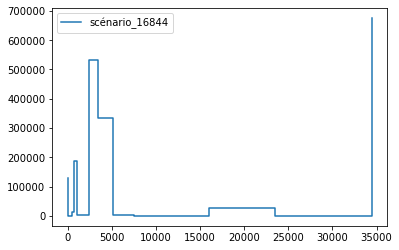

In [17]:
def plot_deep_learning_results(i):
    """
    i : numéro du scénario
    """
    results_deep = np.genfromtxt('hdgp_demo_parameters_subsample.csv',delimiter=',', dtype=int)
    X = results_deep[1,6:27]
    ids = np.argwhere(results_deep[:,0] == i)
    Y = results_deep[ids,27:].flatten()
    X2 = np.zeros(2*X.size, dtype=int)
    X2[1::2], X2[::2] = X, X
    X2 = X2[1:]
    Y2 = np.zeros(2*Y.size, dtype=int)
    Y2[1::2], Y2[::2] = Y, Y
    Y2 = Y2[:-1]
    fig, ax = plt.subplots(1, 1)
    ax.plot(X2, Y2, label=f"scénario_{i}")
    ax.legend()
    
plot_deep_learning_results(16844)